# Spline interpolation

In [1]:
from math import cos, pi
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = [12,8]

### Even distribution of n values between a and b (inclusive)

In [2]:
def even(n, a, b):
    n -= 1
    d = (b - a) / n
    result = [0] * (n + 1)
    result[0] = a
    result[n] = b
    for i in range(1, n):
        result[i] = result[i - 1] + d
    return result

### Cubic spline function generator

In [3]:
# jf zero is True, function calculates with assumption that second derivative equals 0 at boundaries
# if zero is False, function uses 3rd derivative approximation with difference quotient to calculate boundary values

def spline3(X, Y, zero = False):
    n = len(X)
    h = np.array([(X[i+1]-X[i]) for i in range(n-1)])

    matrix = np.zeros((n,n))
    for i in range(1,n-1):
        matrix[i][i-1] = h[i-1]
        matrix[i][i]= 2*(h[i-1]+h[i])
        matrix[i][i+1] = h[i]
    
    # zero is a variable that indicates how we calculate at boundaries
    if zero:
        matrix[0][0] = 1
        matrix[n-1][n-1] = 1
    else:
        matrix[0][0],matrix[0][1] = -h[0], h[0]
        matrix[n-1][n-2],matrix[n-1][n-1] = h[n-2], -h[n-2]

    def rec(i,j):
        if i == j:
            return Y[i]
        else:
            return (rec(i+1, j)-rec(i, j-1))/(X[j]-X[i])


    delta = [(Y[i + 1] - Y[i]) / h[i] for i in range(n - 1)]
    deltaVector = np.zeros(n)
    for i in range(1,n-1):
        deltaVector[i] = delta[i]-delta[i-1]
    if zero:
        deltaVector[0] =0
        deltaVector[n - 1] = 0
    else:
        deltaVector[0] = (h[0] ** 2) * rec(0, 3)
        deltaVector[n-1]= -1*(h[n-2]**2)*rec(n-4,n-1)

    s = np.linalg.solve(matrix,deltaVector)



    def f(x):
        i = 1
        while x > X[i]:
            i+=1
        i -= 1
        b = (Y[i + 1] - Y[i]) / h[i] - h[i] * (s[i + 1] + 2 * s[i])
        c = 3 * s[i]
        d = (s[i + 1] - s[i]) / h[i]
        y = Y[i] + b*(x-X[i]) + c*(x-X[i])**2 + d*(x-X[i])**3
        return y
    return f


### Quadratic spline function generator

In [4]:
# if dxstart is not none, it's used as derivative value at the 'a' point
# otherwise the boundary value is calculated by assumption that function is linear at the 'a' point

def spline2(X, Y, dxstart = None):
    n = len(X)
    h = np.array([(X[i+1]-X[i]) for i in range(n-1)])

    matrix = np.zeros(((n-1)*3,(n-1)*3))
    for i in range(1,3*(n-1)):
        k = i%3
        if k == 1:
            matrix[i][i-1] = 1
        elif k == 2:
            matrix[i][i-2] = 1
            matrix[i][i-1] = h[i//3]
            matrix[i][i] = h[i//3]**2
        else:
            matrix[i][i - 2] = 1
            matrix[i][i - 1] = 2*h[(i-1) // 3]
            matrix[i][i + 1] = -1
    if dxstart is not None:
        matrix[0][1] = 1
    else:
        matrix[0][2] = 1

    r_vector = [None]*(3*(n-1))
    for i in range(0,(n-1)):
        r_vector[3*i] = 0
        r_vector[3*i+1] = Y[i]
        r_vector[3 * i + 2] = Y[i+1]
    if dxstart is not None:
        r_vector[0] = dxstart
    s = np.linalg.solve(matrix,r_vector)
    s = s.reshape((-1,3))

    def f(x):
        i = 1
        while x > X[i]:
            i+=1
        i -= 1
        a = s[i][0]
        b = s[i][1]
        c = s[i][2]
        y = a + b*(x-X[i]) + c*(x-X[i])**2
        return y
    return f

### Mapping an array of values x to an array of f(x)

In [5]:
def function_to_points(X, f): return [f(X[i]) for i in range(len(X))]

### Finding the largest difference

In [6]:
def f_compare_max(Y1,Y2):
    diff = np.abs(Y1 - Y2)
    return np.max(diff)

### Summation of sqared difference of function value for each x in the scope


In [7]:
def f_compare_sqr(Y1,Y2):
    diff = np.square(Y1 - Y2)
    return np.sum(diff)

### Plot generation

In [8]:
def plot(X,Y,f1,f2,a,b):
    X2 = np.linspace(a,b,2000)
    Y1 = f1(X2)
    Y2 = f2(X2)
    plt.plot(X2,Y1,'g')
    plt.plot(X2, Y2, 'b')
    plt.scatter(X,Y,c='r',s=15,marker = 'o')
    plt.show()

### The problem is to interpolate given function:

In [9]:
a,b = -2*pi,pi
def f(x): return np.exp(-3*np.sin(3*x))
dx_at_a = -9
X = np.linspace(a,b,2000)
Y = f(X)

## Evaluating for 8 nodes

In [10]:
n=8

In [11]:
xc = np.array(even(n, a, b))
yc = f(xc)

#cubic spline with approximated 3rd derivative at bounds
cube = spline3(xc,yc)

# cubic spline with 2nd derivatives equal to 0 at bounds
cube_z = spline3(xc,yc,True)

# square spline with linear function at 'a'
sqrspl = spline2(xc,yc)

# square spline with original function's derivative evaluated at 'a'
sqrspl_d = spline2(xc,yc,dx_at_a)

### subic spline with 3rd derivative approximation

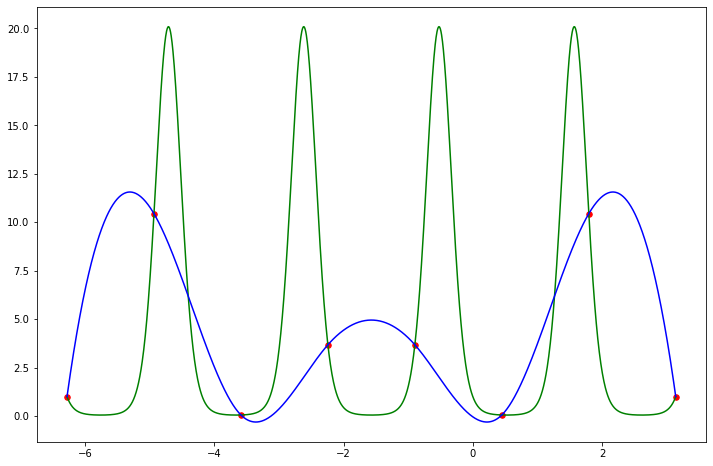

In [12]:
Yc = np.zeros(2000)
for i in range(2000):
    Yc[i] = cube(X[i])
c_max, c_sqr = f_compare_max(Y,Yc), f_compare_sqr(Y,Yc)


plt.plot(X,Y,'g')
plt.plot(X, Yc, 'b')
plt.scatter(xc,yc,c='r',s=30,marker = 'o')

plt.show()

### Cubic spline with zero 2nd derivative 

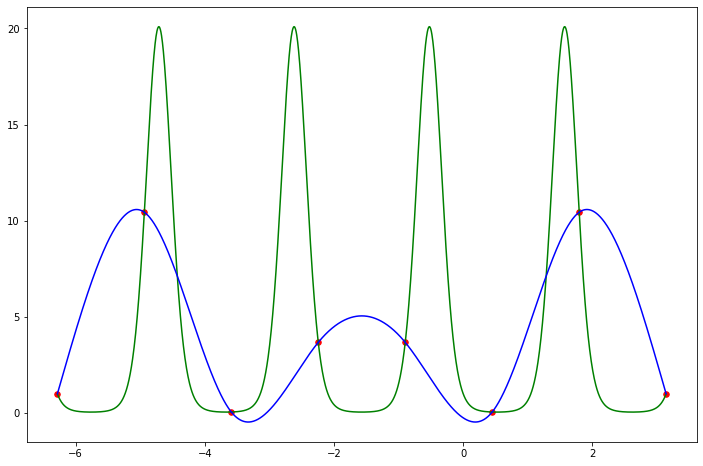

In [13]:
Ycz = np.zeros(2000)
for i in range(2000):
    Ycz[i] = cube_z(X[i])
cz_max, cz_sqr = f_compare_max(Y,Ycz), f_compare_sqr(Y,Ycz)


plt.plot(X,Y,'g')
plt.plot(X, Ycz, 'b')
plt.scatter(xc,yc,c='r',s=30,marker = 'o')

plt.show()

### square spline with linear functions at lower bound

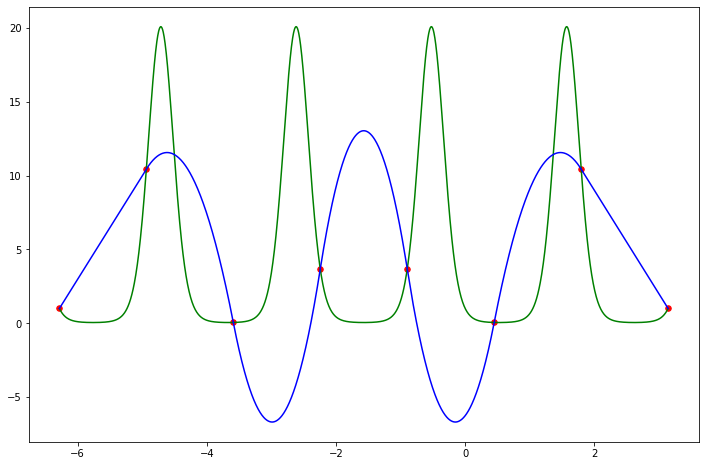

In [14]:
Ys = np.zeros(2000)
for i in range(2000):
    Ys[i] = sqrspl(X[i])
s_max, s_sqr = f_compare_max(Y,Ys), f_compare_sqr(Y,Ys)


plt.plot(X,Y,'g')
plt.plot(X, Ys, 'b')
plt.scatter(xc,yc,c='r',s=30,marker = 'o')

plt.show()

### Square spline with 0 derivative value at lower bound

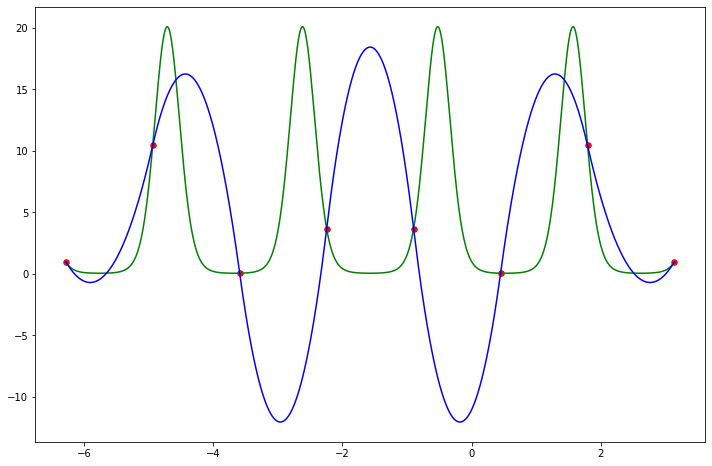

In [15]:
Ysd = np.zeros(2000)
for i in range(2000):
    Ysd[i] = sqrspl_d(X[i])
sd_max, sd_sqr = f_compare_max(Y,Ysd), f_compare_sqr(Y,Ysd)


plt.plot(X,Y,'g')
plt.plot(X, Ysd, 'b')
plt.scatter(xc,yc,c='r',s=30,marker = 'o')

plt.show()

In [16]:
print("c  largest difference: ",round(c_max,2))
print("cz largest difference: ",round(cz_max,2))
print("s  largest difference: ",round(s_max,2))
print("sd largest difference: ",round(sd_max,2))
print()
print("c  sum of sqrd differences: ",round(c_sqr,2))
print("cz sum of sqrd differences: ",round(cz_sqr,2))
print("s  sum of sqrd differences: ",round(s_sqr,2))
print("sd sum of sqrd differences: ",round(sd_sqr,2))

c  largest difference:  18.1
cz largest difference:  18.23
s  largest difference:  24.37
sd largest difference:  28.89

c  sum of sqrd differences:  105518.26
cz sum of sqrd differences:  90490.97
s  sum of sqrd differences:  166136.62
sd sum of sqrd differences:  265543.28


## Evaluating for 20 nodes

In [17]:
n=20

In [18]:
xc = np.array(even(n, a, b))
yc = f(xc)

#cubic spline with approximated 3rd derivative at bounds
cube = spline3(xc,yc)

# cubic spline with 2nd derivatives equal to 0 at bounds
cube_z = spline3(xc,yc,True)

# square spline with linear function at 'a'
sqrspl = spline2(xc,yc)

# square spline with original function's derivative evaluated at 'a'
sqrspl_d = spline2(xc,yc,dx_at_a)

### subic spline with 3rd derivative approximation

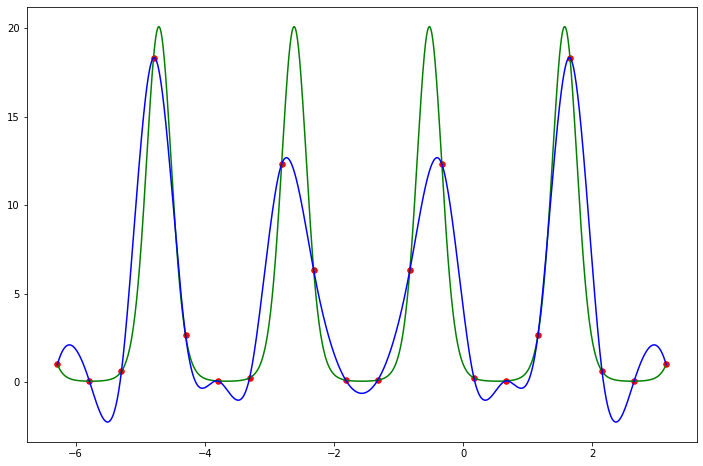

In [19]:
Yc = np.zeros(2000)
for i in range(2000):
    Yc[i] = cube(X[i])
c_max, c_sqr = f_compare_max(Y,Yc), f_compare_sqr(Y,Yc)


plt.plot(X,Y,'g')
plt.plot(X, Yc, 'b')
plt.scatter(xc,yc,c='r',s=30,marker = 'o')

plt.show()

### Cubic spline with zero 2nd derivative 

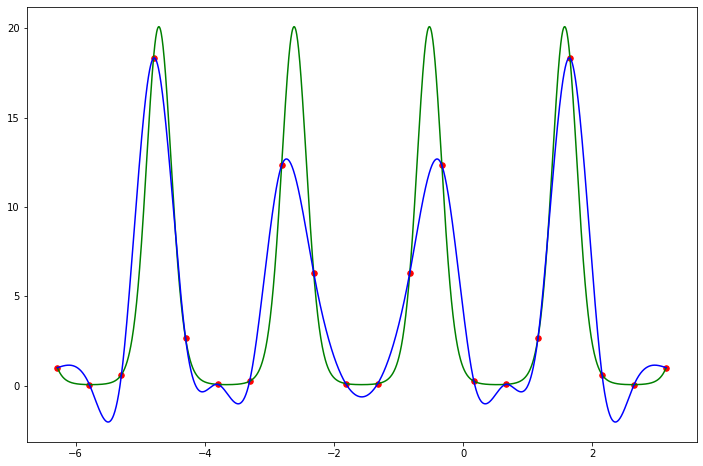

In [20]:
Ycz = np.zeros(2000)
for i in range(2000):
    Ycz[i] = cube_z(X[i])
cz_max, cz_sqr = f_compare_max(Y,Ycz), f_compare_sqr(Y,Ycz)


plt.plot(X,Y,'g')
plt.plot(X, Ycz, 'b')
plt.scatter(xc,yc,c='r',s=30,marker = 'o')

plt.show()

### square spline with linear functions at lower bound

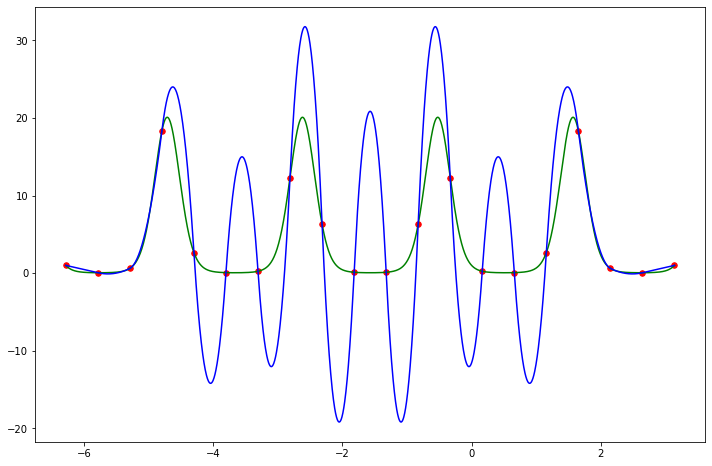

In [21]:
Ys = np.zeros(2000)
for i in range(2000):
    Ys[i] = sqrspl(X[i])
s_max, s_sqr = f_compare_max(Y,Ys), f_compare_sqr(Y,Ys)


plt.plot(X,Y,'g')
plt.plot(X, Ys, 'b')
plt.scatter(xc,yc,c='r',s=30,marker = 'o')

plt.show()

### Square spline with 0 derivative value at lower bound

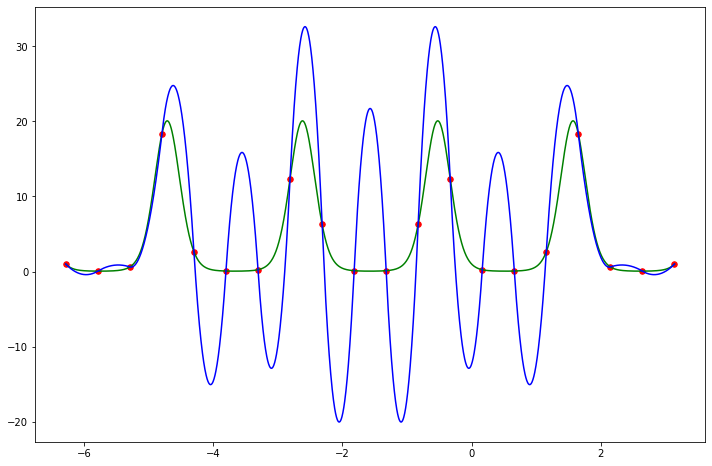

In [22]:
Ysd = np.zeros(2000)
for i in range(2000):
    Ysd[i] = sqrspl_d(X[i])
sd_max, sd_sqr = f_compare_max(Y,Ysd), f_compare_sqr(Y,Ysd)


plt.plot(X,Y,'g')
plt.plot(X, Ysd, 'b')
plt.scatter(xc,yc,c='r',s=30,marker = 'o')

plt.show()

In [23]:
print("c  largest difference: ",round(c_max,2))
print("cz largest difference: ",round(cz_max,2))
print("s  largest difference: ",round(s_max,2))
print("sd largest difference: ",round(sd_max,2))
print()
print("c  sum of sqrd differences: ",round(c_sqr,2))
print("cz sum of sqrd differences: ",round(cz_sqr,2))
print("s  sum of sqrd differences: ",round(s_sqr,2))
print("sd sum of sqrd differences: ",round(sd_sqr,2))

c  largest difference:  8.32
cz largest difference:  8.32
s  largest difference:  20.8
sd largest difference:  21.68

c  sum of sqrd differences:  14705.95
cz sum of sqrd differences:  14208.95
s  sum of sqrd differences:  165928.25
sd sum of sqrd differences:  185335.88


## Evaluating for 35 nodes

In [24]:
n=35

In [25]:
xc = np.array(even(n, a, b))
yc = f(xc)

#cubic spline with approximated 3rd derivative at bounds
cube = spline3(xc,yc)

# cubic spline with 2nd derivatives equal to 0 at bounds
cube_z = spline3(xc,yc,True)

# square spline with linear function at 'a'
sqrspl = spline2(xc,yc)

# square spline with original function's derivative evaluated at 'a'
sqrspl_d = spline2(xc,yc,dx_at_a)

### subic spline with 3rd derivative approximation

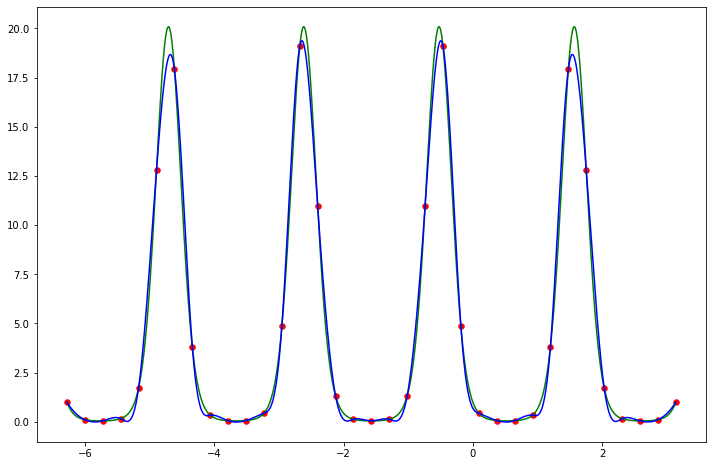

In [26]:
Yc = np.zeros(2000)
for i in range(2000):
    Yc[i] = cube(X[i])
c_max, c_sqr = f_compare_max(Y,Yc), f_compare_sqr(Y,Yc)


plt.plot(X,Y,'g')
plt.plot(X, Yc, 'b')
plt.scatter(xc,yc,c='r',s=30,marker = 'o')

plt.show()

### Cubic spline with zero 2nd derivative 

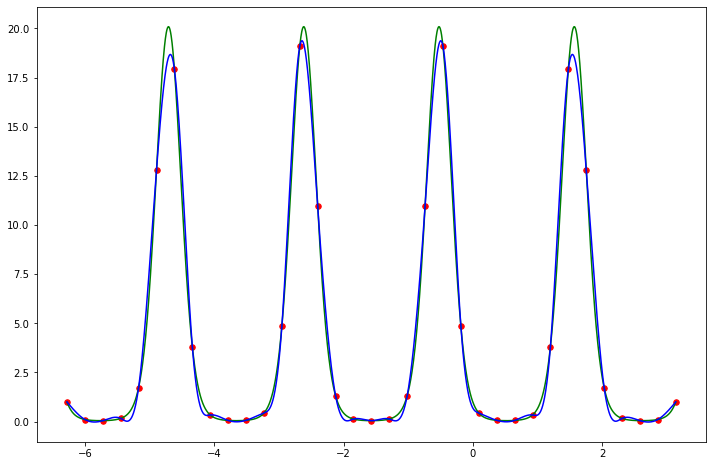

In [27]:
Ycz = np.zeros(2000)
for i in range(2000):
    Ycz[i] = cube_z(X[i])
cz_max, cz_sqr = f_compare_max(Y,Ycz), f_compare_sqr(Y,Ycz)


plt.plot(X,Y,'g')
plt.plot(X, Ycz, 'b')
plt.scatter(xc,yc,c='r',s=30,marker = 'o')

plt.show()

### square spline with linear functions at lower bound

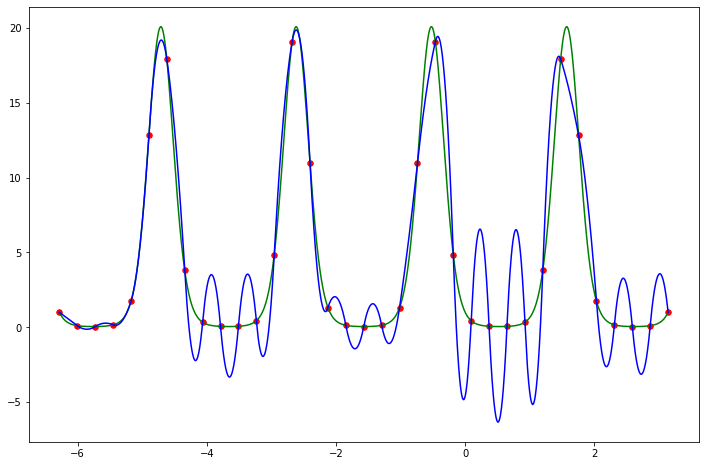

In [28]:
Ys = np.zeros(2000)
for i in range(2000):
    Ys[i] = sqrspl(X[i])
s_max, s_sqr = f_compare_max(Y,Ys), f_compare_sqr(Y,Ys)


plt.plot(X,Y,'g')
plt.plot(X, Ys, 'b')
plt.scatter(xc,yc,c='r',s=30,marker = 'o')

plt.show()

### Square spline with 0 derivative value at lower bound

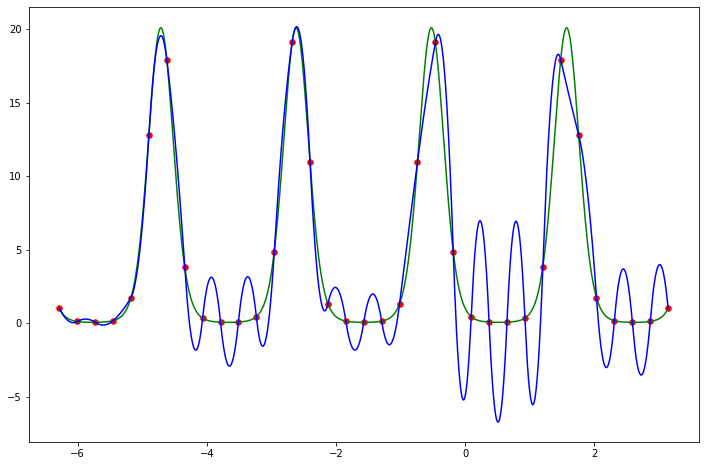

In [29]:
Ysd = np.zeros(2000)
for i in range(2000):
    Ysd[i] = sqrspl_d(X[i])
sd_max, sd_sqr = f_compare_max(Y,Ysd), f_compare_sqr(Y,Ysd)


plt.plot(X,Y,'g')
plt.plot(X, Ysd, 'b')
plt.scatter(xc,yc,c='r',s=30,marker = 'o')

plt.show()

In [30]:
print("c  largest difference: ",round(c_max,2))
print("cz largest difference: ",round(cz_max,2))
print("s  largest difference: ",round(s_max,2))
print("sd largest difference: ",round(sd_max,2))
print()
print("c  sum of sqrd differences: ",round(c_sqr,2))
print("cz sum of sqrd differences: ",round(cz_sqr,2))
print("s  sum of sqrd differences: ",round(s_sqr,2))
print("sd sum of sqrd differences: ",round(sd_sqr,2))

c  largest difference:  1.76
cz largest difference:  1.76
s  largest difference:  6.41
sd largest difference:  6.81

c  sum of sqrd differences:  609.56
cz sum of sqrd differences:  611.27
s  sum of sqrd differences:  12551.72
sd sum of sqrd differences:  14008.27


## Evaluating for 70 nodes

In [31]:
n=70

In [32]:
xc = np.array(even(n, a, b))
yc = f(xc)

#cubic spline with approximated 3rd derivative at bounds
cube = spline3(xc,yc)

# cubic spline with 2nd derivatives equal to 0 at bounds
cube_z = spline3(xc,yc,True)

# square spline with linear function at 'a'
sqrspl = spline2(xc,yc)

# square spline with original function's derivative evaluated at 'a'
sqrspl_d = spline2(xc,yc,dx_at_a)

### subic spline with 3rd derivative approximation

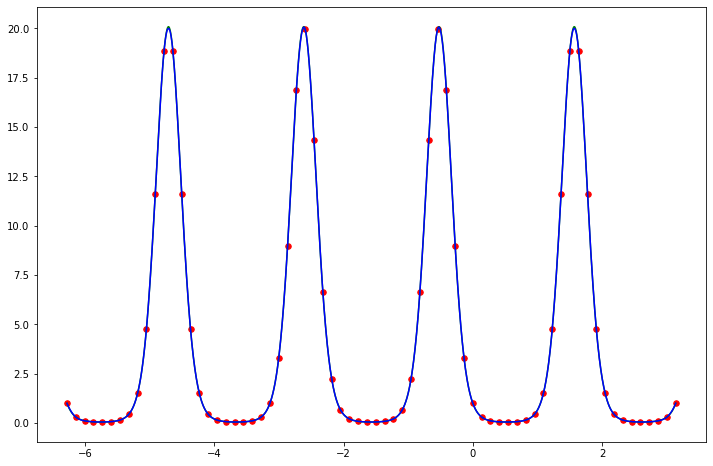

In [33]:
Yc = np.zeros(2000)
for i in range(2000):
    Yc[i] = cube(X[i])
c_max, c_sqr = f_compare_max(Y,Yc), f_compare_sqr(Y,Yc)


plt.plot(X,Y,'g')
plt.plot(X, Yc, 'b')
plt.scatter(xc,yc,c='r',s=30,marker = 'o')

plt.show()

### Cubic spline with zero 2nd derivative 

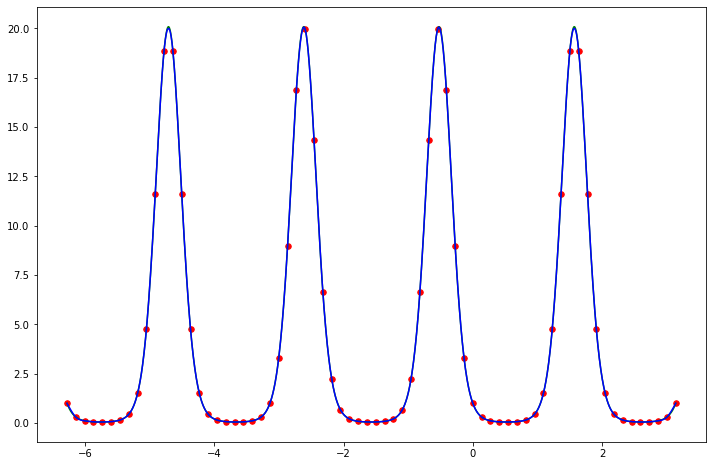

In [34]:
Ycz = np.zeros(2000)
for i in range(2000):
    Ycz[i] = cube_z(X[i])
cz_max, cz_sqr = f_compare_max(Y,Ycz), f_compare_sqr(Y,Ycz)


plt.plot(X,Y,'g')
plt.plot(X, Ycz, 'b')
plt.scatter(xc,yc,c='r',s=30,marker = 'o')

plt.show()

### square spline with linear functions at lower bound

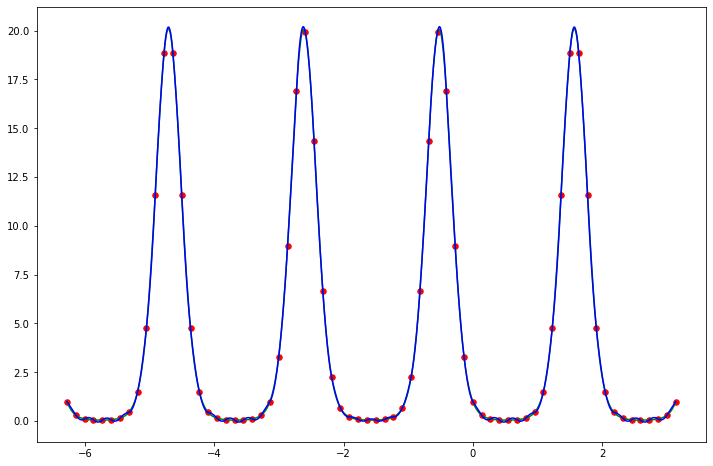

In [35]:
Ys = np.zeros(2000)
for i in range(2000):
    Ys[i] = sqrspl(X[i])
s_max, s_sqr = f_compare_max(Y,Ys), f_compare_sqr(Y,Ys)


plt.plot(X,Y,'g')
plt.plot(X, Ys, 'b')
plt.scatter(xc,yc,c='r',s=30,marker = 'o')

plt.show()

### Square spline with 0 derivative value at lower bound

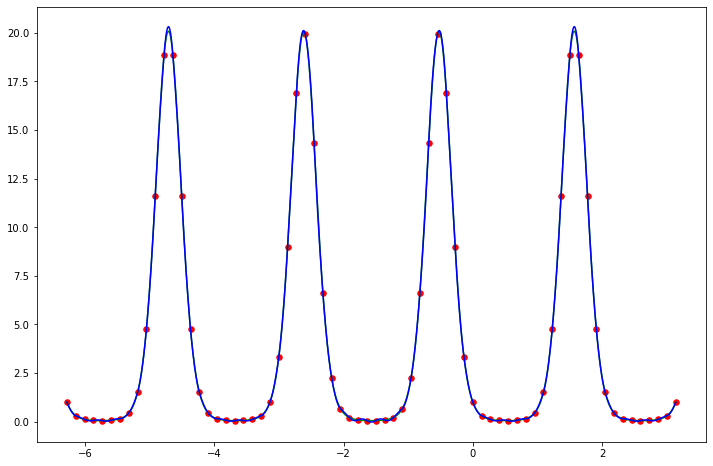

In [36]:
Ysd = np.zeros(2000)
for i in range(2000):
    Ysd[i] = sqrspl_d(X[i])
sd_max, sd_sqr = f_compare_max(Y,Ysd), f_compare_sqr(Y,Ysd)


plt.plot(X,Y,'g')
plt.plot(X, Ysd, 'b')
plt.scatter(xc,yc,c='r',s=30,marker = 'o')

plt.show()

In [37]:
print("c  largest difference: ",round(c_max,2))
print("cz largest difference: ",round(cz_max,2))
print("s  largest difference: ",round(s_max,2))
print("sd largest difference: ",round(sd_max,2))
print()
print("c  sum of sqrd differences: ",round(c_sqr,2))
print("cz sum of sqrd differences: ",round(cz_sqr,2))
print("s  sum of sqrd differences: ",round(s_sqr,2))
print("sd sum of sqrd differences: ",round(sd_sqr,2))

c  largest difference:  0.09
cz largest difference:  0.09
s  largest difference:  0.25
sd largest difference:  0.23

c  sum of sqrd differences:  0.62
cz sum of sqrd differences:  0.74
s  sum of sqrd differences:  12.98
sd sum of sqrd differences:  6.58
